# DETSEC on EGC Dataset


## Data Collection and Transformation

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
df = pd.read_csv(f"data-lag5-forecast5.csv", index_col=0)
data = preprocessing.normalize(df.values)
file = "stock/data.npy"
# np.save(file, data)
lis = [100] * data.shape[0]
seq_length = np.array(lis)
seq_file = "stock/seq_length.npy"
# np.save(seq_file, seq_length)

## Libraries

In [2]:
import sys
import os
import numpy as np
import math
from operator import itemgetter, attrgetter, methodcaller
import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
# from tensorflow.contrib.rnn import DropoutWrapper
import time
import calendar
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
# from tensorflow.contrib import rnn
from scipy.spatial import distance
from operator import itemgetter
import random as rand
from sklearn.cluster import KMeans

In [3]:
from tensorflow.compat.v1.nn.rnn_cell import DropoutWrapper

In [4]:
from tensorflow.compat.v1.nn import rnn_cell as rnn

In [5]:
tf.compat.v1.disable_eager_execution()

In [6]:
tf.compat.v1.reset_default_graph()

## buildMaskBatch

In [7]:
def buildMaskBatch(batch_seql, max_size):
	mask_batch = []
	for el in batch_seql:
		mask_batch.append(  np.concatenate( (np.ones(el), np.zeros(max_size - el)) ) )
	return np.array(mask_batch)

## extractFeatures

In [8]:
def extractFeatures(ts_data, seq_length, mask_val):
	batchsz = 1024
	iterations = int(ts_data.shape[0] / batchsz)
	if ts_data.shape[0] % batchsz != 0:
		iterations+=1
	features = None

	for ibatch in range(iterations):
		batch_data, batch_seqL = getBatch(ts_data, seq_length, ibatch, batchsz)
		batch_mask, _ = getBatch(mask_val, mask_val, ibatch, batchsz)
		partial_features = sess.run(embedding,feed_dict={input_t:batch_data, seqL:batch_seqL, mask: batch_mask})
		if features is None:
			features = partial_features
		else:
			features = np.vstack((features, partial_features))

		del batch_data
		del batch_mask
	return features

## gate and gating

In [9]:
def gate(vec):
    mask = tf.compat.v1.layers.dense(vec, vec.get_shape()[1], activation=tf.sigmoid)
    return mask

In [10]:
def gating(outputs_list, mask):
	gating_results = None
	if mask is None:
		for i in range(len(outputs_list)):
			val = outputs_list[i]
			multiplication = val * gate(val)
			if gating_results is None:
				gating_results = multiplication
			else:
				gating_results = gating_results + multiplication
		return gating_results

	for i in range(len(outputs_list)):
		val = outputs_list[i]
		multiplication = val * gate(val)
		multiplication = tf.compat.v1.transpose( multiplication )
		multiplication = multiplication * mask[:,i]
		multiplication = tf.compat.v1.transpose( multiplication )
		if gating_results is None:
			gating_results = multiplication
		else:
			gating_results = gating_results +multiplication

	return gating_results

## attention

In [11]:
def attention(outputs_list, nunits, attention_size):
	outputs = tf.stack(outputs_list, axis=1)

	# Trainable parameters
	W_omega = tf.compat.v1.Variable(tf.compat.v1.random_normal([nunits, attention_size], stddev=0.1))
	b_omega = tf.compat.v1.Variable(tf.compat.v1.random_normal([attention_size], stddev=0.1))
	u_omega = tf.compat.v1.Variable(tf.compat.v1.random_normal([attention_size], stddev=0.1))

	# Applying fully connected layer with non-linear activation to each of the B*T timestamps;
	#  the shape of `v` is (B,T,D)*(D,A)=(B,T,A), where A=attention_size
	v = tf.compat.v1.tanh(tf.compat.v1.tensordot(outputs, W_omega, axes=1) + b_omega)
	# For each of the timestamps its vector of size A from `v` is reduced with `u` vector
	vu = tf.compat.v1.tensordot(v, u_omega, axes=1)   # (B,T) shape
	alphas = tf.compat.v1.nn.softmax(vu)              # (B,T) shape also

	output = tf.compat.v1.reduce_sum(outputs * tf.compat.v1.expand_dims(alphas, -1), 1)
	output = tf.compat.v1.reshape(output, [-1, nunits])
	return output


## getBatch

In [12]:
def getBatch(X, Y, i, batch_size):
    start_id = i*batch_size
    end_id = min( (i+1) * batch_size, X.shape[0])
    batch_x = X[start_id:end_id]
    batch_y = Y[start_id:end_id]
    return batch_x, batch_y


## AE3

In [13]:

def AE3(x, b_size, n_dim, seqL, mask, toReuse):
	with tf.compat.v1.variable_scope("ENCDEC",reuse=toReuse):
		n_splits = x.get_shape()[1] / n_dim
		n_splits = int(n_splits)
		x_list = tf.compat.v1.split(x, n_splits, axis=1)
		x_list_bw = tf.compat.v1.stack(x_list[::-1],axis=1)
		x_list = tf.compat.v1.stack(x_list,axis=1)
		#FIXED TO 512 for big dataset
		#FOR SMALL DATASET WE RECOMMEND 64 OR 32
		nunits = 64
		outputsEncLFW = None
		outputsEncLBW = None

		with tf.compat.v1.variable_scope("encoderFWL", reuse=toReuse):
			cellEncoderFW = rnn.GRUCell(nunits)
			outputsEncLFW,_=tf.compat.v1.nn.dynamic_rnn(cellEncoderFW, x_list, sequence_length = seqL, dtype="float32")

		with tf.compat.v1.variable_scope("encoderBWL", reuse=toReuse):
			cellEncoderBW = rnn.GRUCell(nunits)
			outputsEncLBW,_=tf.compat.v1.nn.dynamic_rnn(cellEncoderBW, x_list_bw, sequence_length = seqL, dtype="float32")

		final_list_fw = []
		for i in range( n_splits ):
			final_list_fw.append( outputsEncLFW[:,i,:] )

		final_list_bw = []
		for i in range( n_splits ):
			final_list_bw.append( outputsEncLBW[:,i,:] )

		encoder_fw = attention(final_list_fw, nunits, nunits)
		encoder_bw = attention(final_list_bw, nunits, nunits)
		encoder = gate(encoder_fw) * encoder_fw + gate(encoder_bw) * encoder_bw

		x_list2decode = []
		x_list2decode_bw = []
		for i in range(n_splits):
			x_list2decode.append( tf.compat.v1.identity(encoder) )
			x_list2decode_bw.append( tf.compat.v1.identity(encoder) )

		x_list2decode = tf.compat.v1.stack(x_list2decode, axis=1)
		x_list2decode_bw = tf.compat.v1.stack(x_list2decode_bw, axis=1)

		with tf.compat.v1.variable_scope("decoderG", reuse=toReuse):
			cellDecoder = rnn.GRUCell(nunits)
			outputsDecG,_=tf.compat.v1.nn.dynamic_rnn(cellDecoder, x_list2decode, sequence_length = seqL, dtype="float32")

		with tf.compat.v1.variable_scope("decoderGFW", reuse=toReuse):
			cellDecoder = rnn.GRUCell(nunits)
			outputsDecGFW,_=tf.compat.v1.nn.dynamic_rnn(cellDecoder, x_list2decode_bw, sequence_length = seqL, dtype="float32")

		out_list = []
		out_list_bw = []
		for i in range(n_splits):
			temp_cell = outputsDecG[:,i,:]
			tt = tf.compat.v1.layers.dense(temp_cell, n_dim, activation=None)
			out_list.append( tt )

			temp_cell2 = outputsDecGFW[:,i,:]
			tt2 = tf.compat.v1.layers.dense(temp_cell, n_dim, activation=None)
			out_list_bw.append(tt2)

		reconstruct = tf.compat.v1.concat(out_list, axis=1)
		reconstruct2 = tf.compat.v1.concat(out_list_bw[::1], axis=1)

		return reconstruct, reconstruct2, encoder

## dirName, n_dims, n_clusters

In [14]:
dirName = "stock"
n_dims = 10
n_clusters = 3


## output_dir, dataFileName, seqLFileName

In [15]:
output_dir = 'output'
#DATA FILE with size:	(nSamples, (n_dims * max_length) )
dataFileName = dirName+"/data.npy"
#SEQUENCE LENGTH FILE with size: ( nSamples, )
#It contains the sequence length (multiplied by n_dims) for each sequence with positional reference to the data.npy file
#This means that, if a time series has 4 attributes and it has a lenght equal to 20, the corresponding values in the seq_length.npy file will be 80
seqLFileName = dirName+"/seq_length.npy"

## data, n_row, n_col, seqLength, orig_data, orig_seqLength, n_feat

In [16]:
data = np.load(dataFileName)
n_row = data.shape[0]
n_col = data.shape[1]

seqLength = np.load(seqLFileName)

orig_data = data
orig_seqLength = seqLength
n_feat = data.shape[1]


## b_size, dropOut, seqL, input_t, mask, target_t, sess

In [17]:
print(tf.__version__)

2.6.0


In [18]:
b_size = tf.compat.v1.placeholder(tf.float32, () , name="b_size")
dropOut = tf.compat.v1.placeholder(tf.float32, () , name="dropOut")
seqL = tf.compat.v1.placeholder(tf.float32, (None) , name="seqL")
input_t = tf.compat.v1.placeholder(tf.float32, (None, n_feat), name='inputs')
mask = tf.compat.v1.placeholder(tf.float32, (None, n_feat), name='mask')
target_t = tf.compat.v1.placeholder(tf.float32, (None, n_feat), name='target_t')

sess = tf.compat.v1.InteractiveSession()

In [19]:
input_t.get_shape()[1]

100

## reconstruction (forward), reconstruction2 (backward), embedding 

In [20]:

reconstruction, reconstruction2, embedding = AE3(input_t, b_size, n_dims, seqL, mask, False)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:524: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.GRUCell` is deprecated and will be removed "
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecat

## b_centroids, loss_fw, loss_bw, cost, opt

In [21]:
b_centroids = tf.compat.v1.placeholder(tf.float32, (None, embedding.get_shape()[1]), name='b_centroids')
loss_fw = tf.compat.v1.square( (target_t - reconstruction) * mask )
loss_fw = tf.compat.v1.reduce_sum(loss_fw, axis=1)

loss_bw = tf.compat.v1.square( (target_t - reconstruction2) * mask )
loss_bw = tf.compat.v1.reduce_sum(loss_bw, axis=1)

cost = tf.compat.v1.reduce_mean(loss_fw) + tf.compat.v1.reduce_mean(loss_bw)  #+ latent_loss
opt = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

# CLUSTERING REFINEMENT CENTROIDS

## loss_crc, cost_crc, opt_crc, batchsz, hm_epochs, iterations, max_length, best_loss, noise_factor, th, new_centroids, kmeans_labels

In [22]:
loss_crc = tf.compat.v1.reduce_sum(tf.square( embedding - b_centroids ), axis=1)
loss_crc = tf.compat.v1.reduce_mean(loss_crc)

cost_crc = loss_crc + cost
opt_crc = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0001).minimize(cost_crc)

tf.compat.v1.global_variables_initializer().run()

batchsz = 128
hm_epochs = 75

iterations = int(data.shape[0] / batchsz)
max_length = data.shape[1]

if data.shape[0] % batchsz != 0:
    iterations+=1

best_loss = sys.float_info.max
noise_factor = 0.01

th = 25 #number of epochs for the autoencoder pretraining step
new_centroids = None
kmeans_labels = None


In [26]:
loss_crc_list = []
cost_list = []

## Training


In [27]:
for e in range(hm_epochs):
	start = time.time()
	lossi = 0
	data, seqLength = shuffle(data, seqLength, random_state=0)
	costT = 0
	costT2 = 0
	if e < th:
		data, seqLength = shuffle(data, seqLength, random_state=0)
	else:
		mask_val = buildMaskBatch(seqLength, max_length)
		features = extractFeatures(data, seqLength, mask_val)
		kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=random.randint(1,10000000)).fit(features)
		new_centroids = kmeans.cluster_centers_
		kmeans_labels = kmeans.labels_
		embeddings_data = extractFeatures(data, seqLength, mask_val)
		data, seqLength, kmeans_labels = shuffle(data, seqLength, kmeans_labels, random_state=0)

	for ibatch in range(iterations):
		batch_data, batch_seql = getBatch(data, seqLength, ibatch, batchsz)
		mask_batch = buildMaskBatch(batch_seql, batch_data.shape[1])
		cost_L = 0

		#PRETRAINING ENCODER for 50 EPOCHS
		if e < th:
			_, cost_L= sess.run([opt, cost],feed_dict={ input_t:batch_data,
														target_t:batch_data,
														b_size: batch_data.shape[0],
														seqL: batch_seql,
														mask: mask_batch
														})
			cost_C=0
		#COMBINED TRAINING WITH ENCO/DEC + CLUSTERING REFINEMENT
		else:
			batch_km_labels, _ = getBatch(kmeans_labels, kmeans_labels, ibatch, batchsz)
			batch_centroids = []
			for el in batch_km_labels:
				batch_centroids.append( new_centroids[el]  )
			batch_centroids = np.array(batch_centroids)
			_, cost_L, cost_C = sess.run([opt_crc, cost, loss_crc], feed_dict={
													input_t:batch_data,
													target_t:batch_data,
													#centroids: centroids_val,
													b_size: int(batch_data.shape[0]),
													seqL: batch_seql,
													mask: mask_batch,
													b_centroids: batch_centroids
													})

		costT+=cost_L
		costT2+=cost_C
		del batch_data
		del batch_seql
		del mask_batch

	mask_val = buildMaskBatch(seqLength, max_length)
	embedd = extractFeatures(data, seqLength, mask_val)
	kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embedd)
	print("Epoch:",e,"| COST_EMB:",costT/iterations," | COST_CRC: ", costT2/iterations)
	cost_list.append(costT/iterations)
	loss_crc_list.append(costT2/iterations)


Epoch: 0 | COST_EMB: 0.007108181663271453  | COST_CRC:  0.0
Epoch: 1 | COST_EMB: 0.00699419579986069  | COST_CRC:  0.0
Epoch: 2 | COST_EMB: 0.006896724091675231  | COST_CRC:  0.0
Epoch: 3 | COST_EMB: 0.006774001589744652  | COST_CRC:  0.0
Epoch: 4 | COST_EMB: 0.006630130279710684  | COST_CRC:  0.0
Epoch: 5 | COST_EMB: 0.00646437354947603  | COST_CRC:  0.0
Epoch: 6 | COST_EMB: 0.006272838211978081  | COST_CRC:  0.0
Epoch: 7 | COST_EMB: 0.006065871838785747  | COST_CRC:  0.0
Epoch: 8 | COST_EMB: 0.005836299817674059  | COST_CRC:  0.0
Epoch: 9 | COST_EMB: 0.005586560388100605  | COST_CRC:  0.0
Epoch: 10 | COST_EMB: 0.005301939967832474  | COST_CRC:  0.0
Epoch: 11 | COST_EMB: 0.004986471781093214  | COST_CRC:  0.0
Epoch: 12 | COST_EMB: 0.00464805706142985  | COST_CRC:  0.0
Epoch: 13 | COST_EMB: 0.004318107165908688  | COST_CRC:  0.0
Epoch: 14 | COST_EMB: 0.004008156272075163  | COST_CRC:  0.0
Epoch: 15 | COST_EMB: 0.0037430427431390085  | COST_CRC:  0.0
Epoch: 16 | COST_EMB: 0.003526413133

## [Save model](https://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/)

In [29]:
saver = tf.compat.v1.train.Saver()
saver.save(sess, 'stock-cluster-model')

'stock-cluster-model'

## Plot Loss

In [31]:
import matplotlib.pyplot as plt


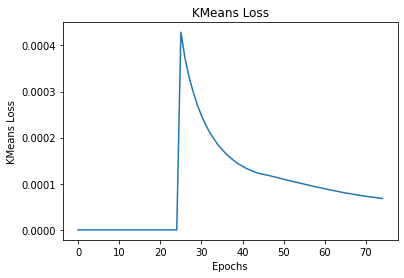

In [32]:
plt.plot(loss_crc_list)
plt.title(f'KMeans Loss')
plt.ylabel('KMeans Loss')
plt.xlabel('Epochs')
plt.savefig(f"KMeans Loss.pdf", dpi = 150)
plt.show()

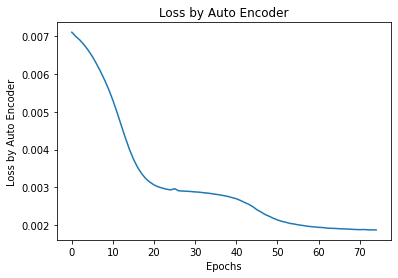

In [33]:
plt.plot(cost_list)
plt.title(f'Loss by Auto Encoder')
plt.ylabel('Loss by Auto Encoder')
plt.xlabel('Epochs')
plt.savefig(f"Loss by Auto Encoder.pdf", dpi = 150)
plt.show()

## output_dir, mask_val, embedd, kmeans, data representation, clustering assignment

In [34]:
output_dir = output_dir+"_detsec512"
if not os.path.exists(output_dir):
	os.mkdir(output_dir)

mask_val = buildMaskBatch(orig_seqLength, max_length)
embedd = extractFeatures(orig_data, orig_seqLength, mask_val)
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embedd)


In [35]:
y = kmeans.labels_ 
y

array([1, 1, 1, ..., 2, 2, 2], dtype=int32)

In [36]:
cluster_0 = df.values[y==0, :]
cluster_1 = df.values[y==1, :]
cluster_2 = df.values[y==2, :]

In [37]:
cluster_0.shape

(3490, 100)

In [38]:
cluster_1.shape

(4792, 100)

In [39]:
cluster_2.shape

(15905, 100)

In [40]:
np.save("cluster_0.npy", cluster_0)
np.save("cluster_1.npy", cluster_1)
np.save("cluster_2.npy", cluster_2)

In [41]:
#SAVE THE DATA REPRESENTATION
np.save("detsec_features.npy", embedd )
#SAVE THE CLUSTERING ASSIGNMENT
np.save("detsec_clust_assignment.npy", np.array(kmeans.labels_) )

In [45]:
embedd.shape

(24187, 64)

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embedd)

In [48]:
principalComponents.shape

(24187, 2)

In [49]:
y_kmeans = kmeans.predict(embedd)

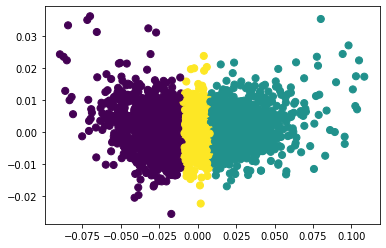

In [51]:
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=y_kmeans, s=50, cmap='viridis')

# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);